## Experiment 3
**Details**: There are several ways to reduces the dimension of embeddings to 2-d or 3-d for visualizing how the embeddings from the same class cluster together, such as principle component analysis (PCA), t-SNE, and UMAP. In this notebook, we employ PCA, t-SNE and UMAP to visualize the embeddings during the training process. In the training, the model is trained for 10 epochs in stage one, and 20 epochs in stage two.

In [1]:
import sys
import umap
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
ROOT = Path.cwd().parent
if str(ROOT) not in sys.path:
    sys.path.append(str(ROOT)) 
if str(ROOT / 'track') not in sys.path:
    sys.path.append(str(ROOT / 'track')) 
if str(ROOT / 'track' / 'yolov5') not in sys.path:
    sys.path.append(str(ROOT / 'track' / 'yolov5'))
import torch
from torch import nn
from torch.nn import functional as F
from torch.nn import TripletMarginLoss
from torch.utils.data import DataLoader
from facenet_pytorch import InceptionResnetV1
from recognition.dataset import TrainingSetLabeled, TrainingSetUnlabeled
from recognition.train import get_device, get_cosine_schedule_with_warmup, evaluate_accuracy
%matplotlib inline

In [2]:
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

In [3]:
def get_all_embeddings(net, LabeledTestLoader):
    '''
    get_all_embeddings: get the embeddings and labels of all samples in the testset.
    '''
    all_embeddings = None
    all_y = None
    with torch.no_grad():
        for X, y in LabeledTestLoader:
            X = X.to(get_device())
            embedding = net(X)
            if all_embeddings is None:
                all_embeddings = embedding
                all_y = y
            else:
                all_embeddings = torch.cat((all_embeddings, embedding), axis=0)
                all_y = torch.cat((all_y, y))
    return all_embeddings, all_y

In [4]:
def train_with_cluster_plot(model, labeled_trainloader, unlabeled_trainloader, labeled_testloader, num_epochs, num_iters, learning_rate, threshold=0.95, cluster='pca'):
    num_epochs = 10 # Fix the number of epochs for this experiment
    plt.figure(figsize=(30, 10))
    name_dict = {'pca': 'PCA', 'tsne': 't-SNE', 'umap': 'UMAP'}
    plt.suptitle(f"Cluster Results using {name_dict[cluster]} During Training", fontsize=30)
    # params_1x: parameters with 1x learning rates
    params_1x = [param for name, param in model.named_parameters() if name not in ["logits.weight", "logits.bias"]]
    grouped_parameters = [
        {'params': params_1x, 'lr': learning_rate},
        {'params': model.logits.parameters(), 'lr': learning_rate*180}
    ]
    optimizer = torch.optim.SGD(grouped_parameters, lr=learning_rate, weight_decay=0.001)
    scheduler = get_cosine_schedule_with_warmup(optimizer, num_warmup_steps=0, num_training_steps=num_epochs*num_iters)
    labeled_iter = iter(labeled_trainloader)
    unlabeled_iter = iter(unlabeled_trainloader)
    device = get_device()    
    if cluster == 'pca':
        cluster_model = PCA(2)
    elif cluster == 'tsne':
        cluster_model = TSNE(2)
    elif cluster == 'umap':
        cluster_model = umap.UMAP()
    # Semi-supevised learning
    model.train()
    for epoch in range(num_epochs):
        print(f"Semi-supervised learning epoch [{epoch+1}/{num_epochs}]")
        for batch_idx in range(num_iters):
            # obtain the labeled batch
            try:
                inputs_x, targets_x = next(labeled_iter)
            except:
                labeled_iter = iter(labeled_trainloader)
                inputs_x, targets_x = next(labeled_iter)
            # obtain te unlabeled batch
            try:
                inputs_u, inputs_u_w = next(unlabeled_iter)
            except:
                unlabeled_iter = iter(unlabeled_trainloader)
                inputs_u, inputs_u_w = next(unlabeled_iter)
                
            num_x = inputs_x.shape[0] # number of labeled images in a batch
            num_u = inputs_u.shape[0] # number of unlabeled imaegs in a batch
            
            # obtain the outputs of the model
            inputs = torch.cat((inputs_x, inputs_u, inputs_u_w)).to(device)
            targets_x = targets_x.to(device)
            logits = model(inputs)
            
            # extract the logits
            logits_x = logits[:num_x]
            logits_u, logits_u_w = logits[num_x:].chunk(2)
            assert logits_u.shape[0] == num_u and logits_u_w.shape[0] == num_u
            del logits
            
            # Supervised loss
            Lx = F.cross_entropy(logits_x, targets_x, reduction='mean')
            
            # Semi-supervised loss
            pseudo_label = torch.softmax(logits_u.detach(), dim=-1)
            max_probs, targets_u = torch.max(pseudo_label, dim=-1)
            mask = max_probs.ge(threshold).float()
            
            total_sum = mask.sum().item()
            
            if total_sum > 0.5: 
                Lu = (F.cross_entropy(logits_u_w, targets_u, reduction='none')*mask).sum() / total_sum
            else:
                Lu = 0
            
            # total loss
            lambda_u = 1.0
            loss = Lx + lambda_u * Lu
            
            loss.backward()
            optimizer.step()
            scheduler.step()
            model.zero_grad()
        # Start cluster plot
        if epoch % 2 == 1:
            model.eval()
            with torch.no_grad():
                model.classify = False
                all_embeddings, all_y = get_all_embeddings(model, labeled_testloader)
                model.classify = True
                data_reduction = cluster_model.fit_transform(all_embeddings.cpu().numpy())
                plt.subplot(2, 5, int((epoch+1)/2))
                plt.scatter(data_reduction[:,0], data_reduction[:,1], c=all_y)
                plt.xticks([])
                plt.yticks([])
            model.train()

    # Triplet Loss Fine-tune
    print("Start Triplet Fine-Tuning......")
    model.classify = False
    params_1x = [param for name, param in model.named_parameters() if name not in ["logits.weight", "logits.bias"]]
    grouped_parameters = [
        {'params': params_1x, 'lr': learning_rate*20},
        {'params': model.logits.parameters(), 'lr': 0}
    ]
    optimizer = torch.optim.SGD(grouped_parameters, lr=learning_rate, weight_decay=0.001)
    scheduler = get_cosine_schedule_with_warmup(optimizer, num_warmup_steps=0, num_training_steps=num_epochs*num_iters)
    
    triplet_loss = nn.TripletMarginLoss(margin=1, p=2)
    device = get_device()
    model.classify = False
    model.eval()
    for epoch in range(25):
        model.eval()
        labeled_iter = iter(labeled_trainloader)
        all_embeddings = None
        all_ys = None
        for X, y in labeled_iter:
            X = X.to(device)
            embedding = model(X)
            if all_embeddings is None:
                all_embeddings = embedding
                all_ys = y
            else:
                all_embeddings = torch.cat((all_embeddings, embedding))
                all_ys = torch.cat((all_ys, y))                
        # Form the triplets: (anchor, hard positive, hard negative)
        anchor, positive, negative = None, None, None
        for idx, (e, y) in enumerate(zip(all_embeddings, all_ys)):
            max_pos_dist, max_pos = -1, None
            min_neg_dist, min_neg = float('inf'), None
            for idx1, (e1, y1) in enumerate(zip(all_embeddings, all_ys)):
                if idx == idx1:
                    continue
                if y != y1:
                    curr_dist = (e-e1).norm().item()
                    if curr_dist < min_neg_dist:
                        min_neg_dist = curr_dist
                        min_neg = e1
                else:
                    curr_dist = (e-e1).norm().item()
                    if curr_dist > max_pos_dist:
                        max_pos_dist = curr_dist
                        max_pos = e1
            if anchor is None:
                anchor, positive, negative = e.unsqueeze(0), max_pos.unsqueeze(0), min_neg.unsqueeze(0)
            else:
                anchor, positive, negative = torch.cat((anchor, e.unsqueeze(0))), torch.cat((positive, max_pos.unsqueeze(0))), torch.cat((negative, min_neg.unsqueeze(0)))
                
        loss = triplet_loss(anchor, positive, negative)
        loss.backward()
        optimizer.step()
        scheduler.step()
        model.zero_grad()

        if (epoch+1)%5 == 0:
            model.eval()
            with torch.no_grad():
                all_embeddings, all_y = get_all_embeddings(model, labeled_testloader)
                plt.subplot(2, 5, int((epoch+1)/2))
                plt.scatter(data_reduction[:,0], data_reduction[:,1], c=all_y)
                plt.xticks([])
                plt.yticks([])
    plt.savefig(f'results/{cluster}.jpg')

In [5]:
def train(source, face_folder, test_folder, cluster='tsne'):
    '''
    train():
        This function is used to tune the pretrained face recognition network using the semi-supervised learning + triplet loss, 
        and plot the clustering results during the training process.
    inputs:
        source: path to the video source
        face_folder: path to the face labeled set
        test_folder: path to the face test set
        cluster: cluster methods, should be one of ['pca', 'tsne', 'umap']
    NOTE: All images in the training set are in the RGB format!
    '''
    # Load small labeled dataset provided by the user
    print("Loading the labeled dataset......")
    LabeledTrainSet = TrainingSetLabeled(face_folder)
    LabeledTrainLoader = DataLoader(LabeledTrainSet, batch_size=8, shuffle=True)
    # Load unlabeled dataset obtained from the video
    print("Loading the unlabeled dataset......")
    UnlabeledTrainSet = TrainingSetUnlabeled(source, "data", num_images=2048)
    UnlabeledTrainLoader = DataLoader(UnlabeledTrainSet, batch_size=8*10, shuffle=True)
    # Load large labeled testset
    print("Loading the labeled testset......")
    LabeledTestSet = TrainingSetLabeled(test_folder, transform=False)
    LabeledTestLoader = DataLoader(LabeledTestSet, batch_size=8, shuffle=False)
    # Get the number of characters of interest
    num_classes = LabeledTrainSet.get_num_classes()
    # Load pretrained face recognition network
    fr_model = InceptionResnetV1(
        classify=True,
        pretrained='vggface2',
        num_classes=num_classes
    ).to(get_device())
    # Initialize the weight-parameters of the classification 
    nn.init.xavier_uniform_(fr_model.logits.weight)
    # Tune the face recognition network using semi-supervised training + triplet loss
    print("Start training the recognition network......")
    train_with_cluster_plot(fr_model, LabeledTrainLoader, UnlabeledTrainLoader, LabeledTestLoader, num_epochs=10, num_iters=40, learning_rate=1.5e-4, threshold=0.99, cluster=cluster)
    print("Finish training the recognition network......")

**Experiment Details**

To do the experiments, you need to replace `source`, `face_folder`, `face_folder_1`, and `test_folder` to your own paths.

In [6]:
source = "../datasets/vct2/vct2.mp4"        # video link 
face_folder = "../datasets/vct2/face/"      # face folder containing 2 images / person
test_folder = "../datasets/vct2/test/"      # test images folder

Loading the labeled dataset......
Loading the unlabeled dataset......
Loading the labeled testset......
Start training the recognition network......
Semi-supervised learning epoch [1/10]
Semi-supervised learning epoch [2/10]
Semi-supervised learning epoch [3/10]
Semi-supervised learning epoch [4/10]
Semi-supervised learning epoch [5/10]
Semi-supervised learning epoch [6/10]
Semi-supervised learning epoch [7/10]
Semi-supervised learning epoch [8/10]
Semi-supervised learning epoch [9/10]
Semi-supervised learning epoch [10/10]
Start Triplet Fine-Tuning......
Finish training the recognition network......


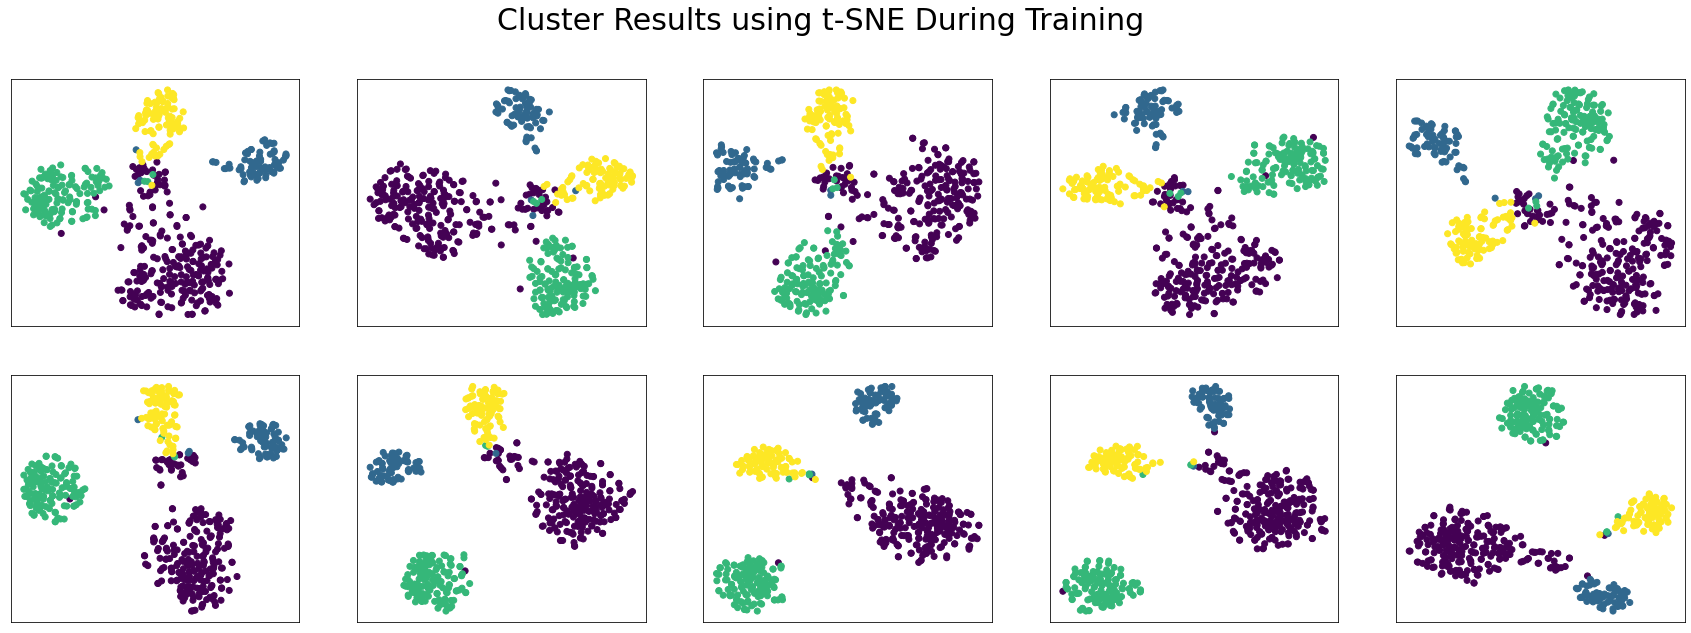

In [7]:
train(source, face_folder, test_folder, cluster='tsne')